# Demography: Document Exploration Notebook

This document allows you to explore:

* The top words for any topic in any $K$-topic model trained on demography dataset
* The top documents of any $K$-topic model trained on the demography dataset
* A few additional plots summarizing the document $\theta$ values

## Set-up

**Imports**

In [1]:
from gensim.models.ldamodel import LdaModel
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from imp import reload

C:\Users\kcsky\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Scripts and paths

In [2]:
from filepaths import code_path
from filepaths import demog_data_path as data_path
from filepaths import demog_models_path as model_path
from filepaths import demog_models_matrix_path as matrix_path

sys.path.insert(0,code_path)
import LdaOutput
import LdaOutputDocs
import LdaOutputWordPlots
import AbstractCleaner
import LdaOutputTimePlots

Data

In [3]:
TM_data = pd.read_csv(os.path.join(data_path, "Demog_data_final.csv"))#, index_col = 0)
year_labels = TM_data.Year

Corpus and dictionary, cleaned abstracts

In [4]:
#sociology
filepath = os.path.join(data_path, "Demog_abstracts4_FreqFilter.pickle")
with open(filepath, "rb") as fp:   #Unpickling
    cleaned_docs = pickle.load(fp)
print(len(AbstractCleaner.extract_vocab(cleaned_docs)), "words in vocab")
print(AbstractCleaner.corpus_length(cleaned_docs), "words in corpus")
corpus, dictionary = AbstractCleaner.get_corpus_and_dictionary(cleaned_docs)

3257 words in vocab
247319 words in corpus


Models

In [5]:
Kvals = [5, 10, 15, 20, 25, 30 ,35, 40, 50,60]
fnames = ["Best_%d_model"%k for k in Kvals]
model_dict = {}
for i,k in enumerate(Kvals):
    model_dict[k] = LdaModel.load(os.path.join(model_path,fnames[i]))
    

Theta matrices
* each of these has dimension K x D where K is the number of topics and D the number of documents
* the (k,d) entry contains the probability that words in document d come from topic k

In [6]:
Kvals = [5, 10, 15, 20, 25, 30 ,35, 40, 50, 60]
fnames = ["theta_matrix_" + str(k) + ".npy" for k in Kvals]
theta_dict = {}
for i, k in enumerate(Kvals):
    theta_dict[k] = np.load(os.path.join(matrix_path, fnames[i]))

# Top Word Explorer

* examine topic in terms of its top words and size over time

In [7]:
#choose settings
k = 20
topic_id = 14
value_type = "counts" #other option is probabilities
sizetype = "word_count" #other options are "doc_count" and "mean"
lamb = 0.6 #from relevance calculation
topn = 20 #number of top words to show

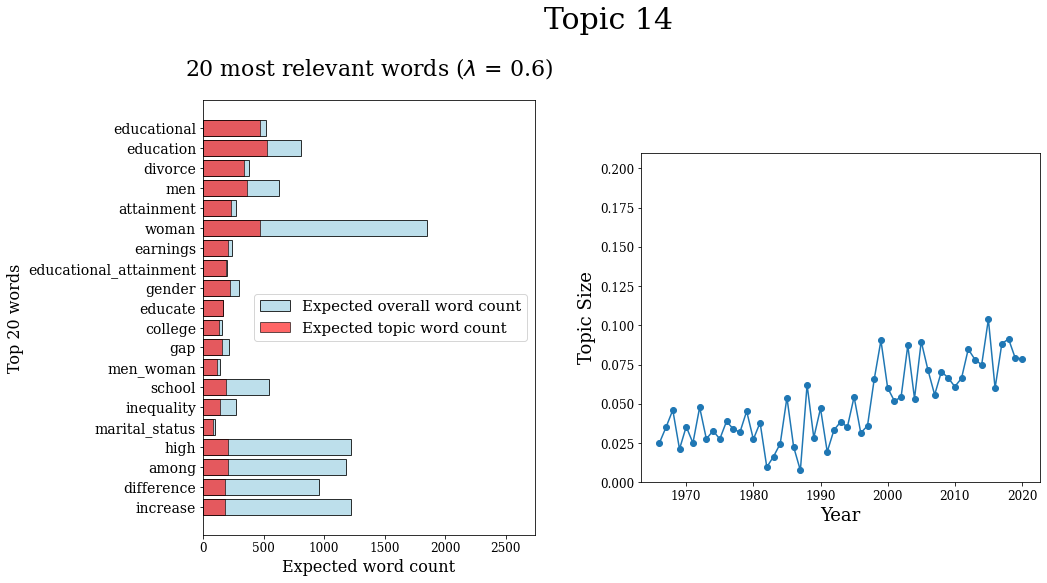

In [8]:
doc_lengths = LdaOutput.get_doc_lengths(corpus)

per_year_size_dict = LdaOutput.get_per_group_topic_size(theta_dict[k], 
                                   label_list = year_labels,
                                   sizetype = sizetype, 
                                   doc_lengths = doc_lengths,
                                   normalized = True)

LdaOutputTimePlots.plot_barplot_and_timeplot(model = model_dict[k],
                                             per_year_size_dict = per_year_size_dict,
                                             custom_suptitle = "Topic %d" % topic_id,
                                             theta_mat = theta_dict[k],
                                             topic_id = topic_id,
                                             figsize = (15,10),
                                             detect_max_vals = True,
                                             corpus = corpus,
                                             dictionary = dictionary,
                                             value_type = value_type,
                                             right_zoom = 1, #avoid plotting 2021
                                             topn = topn, 
                                             lamb = lamb)
                                             #sizelabel = "Normalized expected word counts \n",
                        

# Document explorer: overall

First, set key parameters
* k is number of topics
* i is the topic id # (must be in [0,k)
* topd is number of top documents to view
* latex = True means function outputs table as latex formated string
* omit_abstract = True means table does not include article abstracts

In [9]:
k = 20
i = 14
topd = 10
latex = False
omit_abstract = True

Produce output

In [10]:
output = LdaOutputDocs.get_topic_topdoc_table(TM_data,
                                 theta_dict[k], 
                                 topic_id = i,
                                 topd = topd, 
                                 latex = latex, 
                                 omit_abstract = omit_abstract)


View output
* **tip**: for latex, add print(output) to get easier-to-read form

In [11]:
if latex:
    print(output)
output

,Year,Journal,Title,Theta
0,2017,Demography,"Educational Pairings, Motherhood, and Women’s Relative Earnings in Europe",0.88
1,2021,Demography,The Nonlinear Linkage Between Earnings Homogamy and Earnings Inequality Among Married Couples,0.81
2,2010,Demography,Educational assortative mating and economic inequality: A comparative analysis of three latin American countries,0.81
3,2021,Demography,"Revealing the Concealed Effect of Top Earnings on the Gender Gap in the Economic Value of Higher Education in the United States, 1980-2017",0.75
4,2013,Demography,"Educational Homogamy and Gender-Specific Earnings: Sweden, 1990-2009",0.72
5,2018,Demography,Growing Wealth Gaps in Education,0.69
6,2018,Demography,"Trends in the Motherhood Wage Penalty and Fatherhood Wage Premium for Low, Middle, and High Earners",0.69
7,2012,Demography,Educational Assortative Mating and Income Inequality in Denmark,0.68
8,2013,Demography,The Educational Gradient in Marriage: A Comparison of 25 European Countries,0.66
9,2013,Demography,Explaining the Gender Wealth Gap,0.63


# Distribution of $\theta$ values 

The above only gives the top documents. The plots below visualize the distribution of all document $\theta$ values for a given topic.

In [12]:
k = 20 #choose model
topic_id = 13 #choose topic

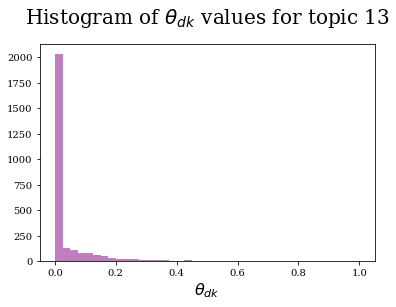

In [13]:
_ = LdaOutputDocs.theta_hist(theta_dict[k],
                         topic_id = topic_id,
                         remove_zeros = False, #set True to only look dist of non-zeros
                         bins = 40, 
                         color = "purple",
                         alpha = 0.5,
                         title = "Histogram of $\\theta_{dk}$ values for topic %d" %topic_id,
                         xlabel = r"$\theta_{dk}$",
                         density = False)

# Document Trajectories

* warning: this can take some time to load

**Explanation:**
* this plot ignores soft clustering and affiliates each document with the topic for which it has the largest $\theta_{dk}$
* plot_all = True is not recommended because the plot is usually incomprehensible (too many document trajectories at once). Instead, you can specify "root_k" and "topic_id" arguments. The function will show trajectories for all documents "affiliated" with topic "topic_id" in the  "root_k"-topic model
* there is no requirement that topics in two different models with the same topic ID # are the same topic (label switching can happen) but topics can be traced by looking at how groups of documents move together. In this way, plot can also help identify topic splitting. For example, if a large number of documents affiliated with topic 4 (say) in model $k$ become affiliated with topic 8 in model $k+5$, then perhaps there has been a label switch and topics 4 and 8 are similar. If many documents from 4 go to 8 but another sizable group go to 10, that might suggest splitting. If there are only a few breakaways of documents from topic 4 to other topic IDs, then this could arise from some noisiness, including where theta values slightly shift to change the relative size rankings of a document's component topics.
* **fact that a document changes affiliation does not mean it no longer draws on its old topic**. This is the drawback of ignoring soft clustering.

As an example, try root_k = 15, topic_id = 13 to see the topic splitting into topics 13 and 11 in the 20-topic model

In [14]:
#plot will only show trajectories of documents affiliated with topic <topic_id> in the <root_k>-topic model
root_k = 15
topic_id = 13

#warning, if set this to True, plot is usually incomprehensible because plots all 2000+ documents trajectories at once
plot_all = False

#use these to restrict the range of k-values plotted
min_K = None
max_K = 60

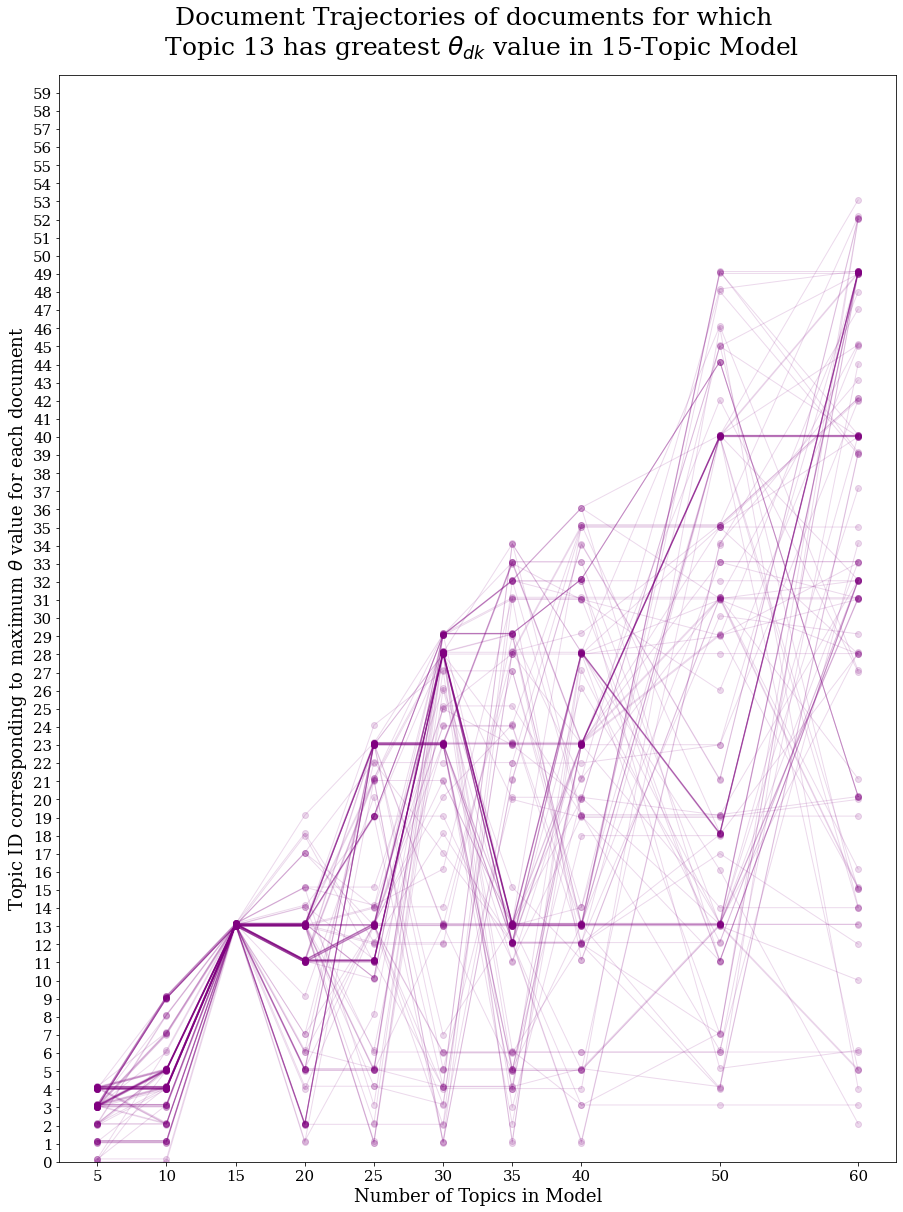

In [15]:
LdaOutputDocs.plot_doc_trajectories(theta_dict = theta_dict,
                      root_k = root_k,
                      topic_id = topic_id,
                      plot_all = False,
                      min_K = min_K,
                      max_K = max_K,
                      single_color = "purple",
                      cmap = "tab20", 
                      figsize = (15,20),
                      shift_width = True)
               

# Number of topics per document

* this function allows you to you examine the distribution of the number of topics with non-zero $\theta$ values per document. Keep in mind that some may be quite small.

In [16]:
k = 30

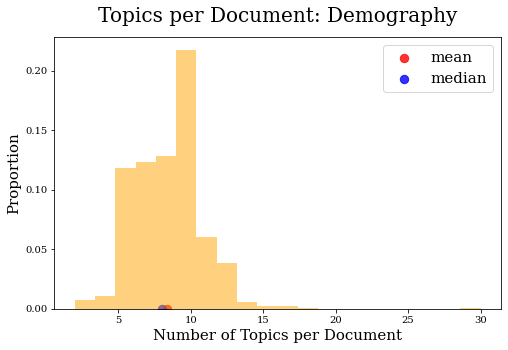

In [17]:
_ = LdaOutputDocs.topics_per_doc_summary(theta_dict[k],
                                     bins = 20,
                                     plot = True, 
                                     custom_title = "Topics per Document: Demography")

The plot below shows that the average number of topics per document increases with $k$

Text(0, 0.5, 'Mean number of topics per document')

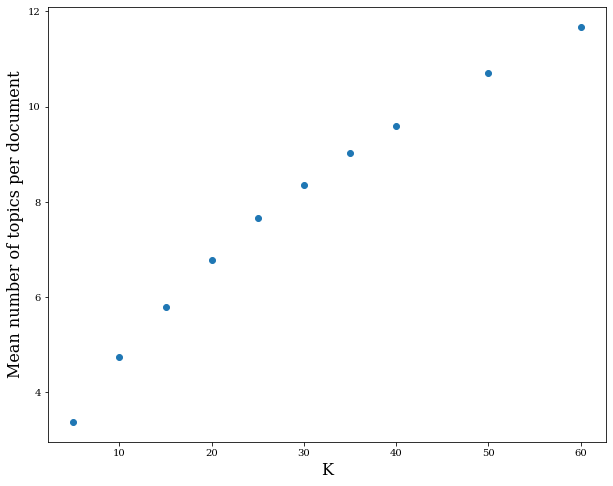

In [18]:
means = [LdaOutputDocs.topics_per_doc_summary(theta_dict[k])["mean"] for k in Kvals]
plt.figure(figsize = (10,8))
plt.scatter(Kvals, means)
plt.xlabel("K", fontsize = 16)
plt.ylabel("Mean number of topics per document", fontsize = 16)